In [1]:
import os
import pathlib
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

C:\Users\Vaibhav\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Vaibhav\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Vaibhav\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [38]:
# Defining the path for train and \test images
train_path = "./dataset/train/"
test_path = "./dataset/test/"

data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [39]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
# image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
# print(image_count_test)

5170


### Create a dataset

Define some parameters for the loader

In [40]:
batch_size = 32
img_height = 50
img_width = 50
image_size = (img_height, img_width)

Use 80% of the images for training, and 20% for validation.

In [41]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

Found 5170 files belonging to 11 classes.
Using 4136 files for training.


In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

Found 5170 files belonging to 11 classes.
Using 1034 files for validation.


In [45]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

Found 880 files belonging to 11 classes.


In [26]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['OK', 'call_me', 'dog', 'index_point_up', 'point_up', 'raised_fist', 'raised_hand', 'rock_on', 'thumbs_up', 'victory', 'wish_to_prosper']


### Visualize the data

#### Visualize images

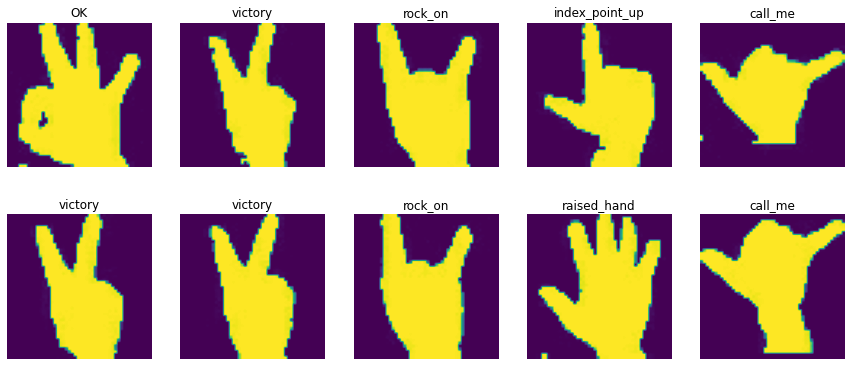

In [27]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
num_classes

11

In [30]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),

    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               5120128   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [33]:
%%time
epochs = 2
history_1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
130/130 [==============================] - 25s 106ms/step - loss: 0.2305 - accuracy: 0.9328 - val_loss: 0.0126 - val_accuracy: 0.9990
Epoch 2/2
130/130 [==============================] - 11s 87ms/step - loss: 0.0210 - accuracy: 0.9956 - val_loss: 0.0047 - val_accuracy: 0.9990
Wall time: 35.9 s


## Save model
Create models folder and store trained model

In [34]:
def save_model(model_path):
    # Create folder if not exists    
    if not os.path.exists(model_path):
        print(f"Path {model_path} is not exist. Creating folder to store models.")
        os.mkdir(model_path)

    model_version = len(os.listdir(model_path)) + 1
    model_name = f"emoji_{model_version}"
    model_name_path = f'{model_path}/{model_name}'
    
    # save model
    model.save(f'{model_name_path}/my_model.h5')
    print(f"Model '{model_name}' is saved successfully to path '{model_path}' !!")

In [35]:
# call function
save_model('models')

Model 'emoji_3' is saved successfully to path 'models' !!


## Let's predict

Visualize actual and predicted image by model

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    return predicted_class, round(confidence, 2)

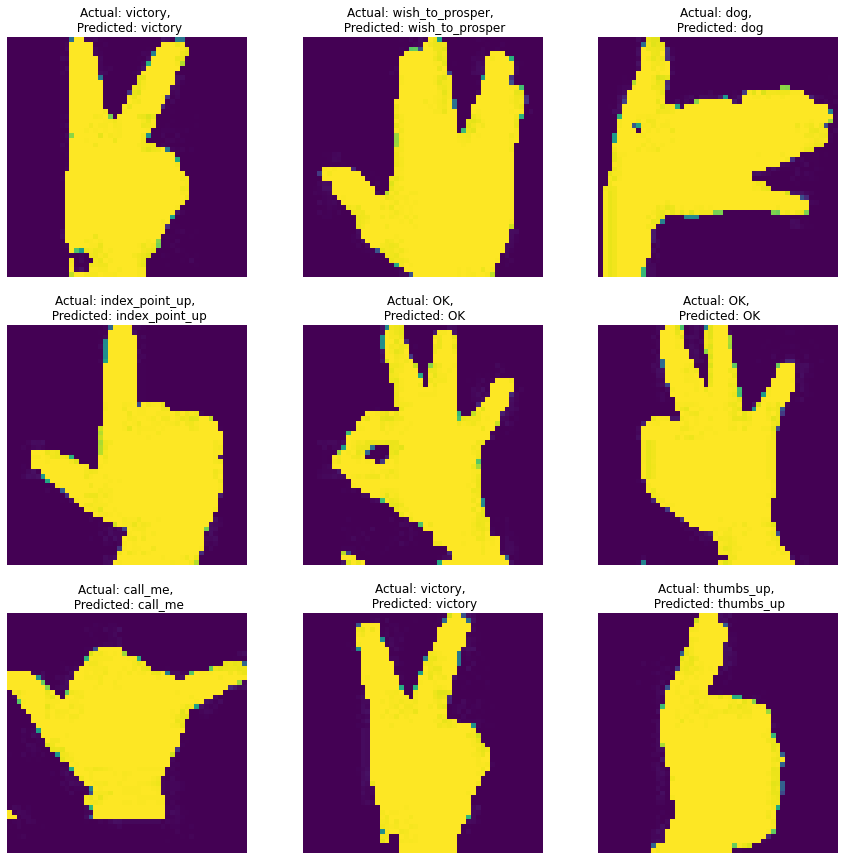

In [46]:
tak = test_ds.take(1)

plt.figure(figsize=(15, 15))
for images, labels in tak:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)

        plt.imshow(images[i].numpy().astype("uint8"))
        image_1 = images[i].numpy()
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}")        
        plt.axis("off")